<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(9, 229, 108);">
    <h3 style="font-weight: bold; font-size: 30px;">Multilevel Analysis
</div>


To investigate how content of posts influence consumer engagement across brand types, we employed linear mixed-effects models (multilevel models). These models account for both fixed effects (average effects across all posts) and random effects (variation by brand category). Specifically, we modelled number of likes and number of comments as outcome variables, with unrealistic beauty portrayals and influencer content as predictors. Brand category (Luxury, Midrange, Drugstore) was included as a random grouping factor, allowing both the intercept and the slopes of the predictors to vary across brands, as shown below in the formula  
 
 This approach captures not only the general trends in engagement but also how the effectiveness of content strategies shifts depending on brand tier. By using this method, we were able to detect nuanced differences in how audiences respond to content across distinct market segments. Insights that would be obscured by standard single-level models. To guide this study, the following hypotheses were formulated: 

H1: Posts containing unrealistic beauty portrayals will receive lower engagement (likes and comments). 

H2: Posts featuring influencer content will generate higher engagement. 

H3: The effects of unrealistic beauty and influencer content on engagement vary across brand categories (luxury, midrange, drugstore). 

In [1]:
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pymer4.models import Lmer
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='rpy2')



# --- Data Preparation ---

In [2]:
# Load Spacy's Named Entity Recognition (NER) model
nlp = spacy.load("en_core_web_sm")

In [3]:
df_LUXURY = pd.read_excel(r"C:\Users\RUTA\Desktop\masters of digital driven bussines\Digital markating\data brands\TEAM%204%20-%20DMS_2025310_146 (1).xlsx")
Midrange   = pd.read_excel(r"C:\Users\RUTA\Desktop\masters of digital driven bussines\Digital markating\data brands\TEAM%204%20-%20DMS_2025310_141.xlsx")
Drugstore  = pd.read_excel(r"C:\Users\RUTA\Desktop\masters of digital driven bussines\Digital markating\data brands\TEAM%204%20-%20DMS_2025310_1333.xlsx")
# Rename columns for consistency
# Rename columns for consistency
rename_mapping = {
    'Unnamed: 1': 'Date',
    'Unnamed: 2': 'Message',
    'Unnamed: 3': 'Profile',
    'Unnamed: 4': 'Network',
    'Unnamed: 5': 'Number of Likes',
    'Unnamed: 6': 'Number of Comments',
    'Unnamed: 7': 'Reactions',
    'Unnamed: 8': 'Post interaction rate',
    'Unnamed: 9': 'Reach per post',
    'Unnamed: 10': 'Interactions per impression',
    'Unnamed: 11': 'Post comments negative sentiment share',
    'Unnamed: 12': 'Engagement rate',
    'Unnamed: 13': 'Click-through rate (CTR)',
    'Unnamed: 14': 'Impressions',
    'Unnamed: 15': 'Message-ID',
    'Unnamed: 16': 'Profile-ID',
    'Unnamed: 17': 'Link',
    'Unnamed: 18': 'External Links'
}


df_LUXURY = df_LUXURY.rename(columns=rename_mapping)
Midrange   = Midrange.rename(columns=rename_mapping)
Drugstore  = Drugstore.rename(columns=rename_mapping)


In [4]:
Drugstore['Profile'].unique()


array(["L'Oréal Paris Official", 'Revlon', 'Maybelline New York',
       'NYX Professional Makeup', 'wet n wild beauty', 'Milani Cosmetics',
       'e.l.f. Cosmetics and Skincare', 'COVERGIRL', 'Physicians Formula',
       'Rimmel London US'], dtype=object)

In [5]:
df_LUXURY = df_LUXURY.drop([col for col in df_LUXURY.columns if isinstance(col, str) and col.startswith("Unnamed")], axis=1)
Midrange   = Midrange.drop([col for col in Midrange.columns if isinstance(col, str) and col.startswith("Unnamed")], axis=1)
Drugstore  = Drugstore.drop([col for col in Drugstore.columns if isinstance(col, str) and col.startswith("Unnamed")], axis=1)

In [6]:
merged_df = pd.concat([df_LUXURY, Midrange], ignore_index=True)
merged_df.head()

print(merged_df.shape)

(10000, 18)


In [7]:
merged_df = pd.concat([merged_df, Drugstore], ignore_index=True)


In [8]:
# Drop rows where 'Message' is NaN or empty
merged_df = merged_df[merged_df['Message'].notna() & (merged_df['Message'].str.strip() != '')]

# Then create the binary influencer post column
merged_df['post_by_influencer'] = merged_df['Message'].str.contains(r'@\w+', regex=True).astype(int)


In [9]:
merged_df['post_by_influencer'].value_counts()

post_by_influencer
0    13069
1     1926
Name: count, dtype: int64

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    return text

merged_df['clean_message'] = merged_df['Message'].astype(str).apply(clean_text)


In [12]:
import pandas as pd
import re

### 1 Text Preprocessing Function ###
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    return text

# Apply cleaning function on the 'Message' column and store the result in 'clean_message'
merged_df['clean_message'] = merged_df['Message'].astype(str).apply(clean_text)

### 2 Identify Brand Mentions in Messages ###
brands = [
    # Luxury Brands
    "chanel beauty", "dior beauty", "tom ford beauty", "yves saint laurent beauty",
    "ysl beauty", "guerlain", "la mer", "estée lauder", "cle de peau beaute",
    "sisley paris", "lancôme",

    # Mid-Range Brands
    "mac cosmetics", "urban decay cosmetics", "nars cosmetics", "benefit cosmetics",
    "too faced cosmetics", "tarte cosmetics", "smashbox cosmetics", "fenty beauty",
    "huda beauty", "glossier",

    # Drugstore Brands
    "maybelline new york", "l'oréal paris", "revlon", "covergirl", "e l f cosmetics",
    "nyx professional makeup", "rimmel london", "milani cosmetics",
    "wet n wild beauty", "physicians formula"
]

def find_brands(text):
    found_brands = [brand for brand in brands if brand in text]
    return ", ".join(found_brands) if found_brands else "No Brand Mentioned"

merged_df['identified_brands'] = merged_df['clean_message'].apply(find_brands)

### 3 Detecting Unrealistic Beauty Content ###
unrealistic_keywords = [
    "flawless", "porcelain", "airbrushed", "wrinkle-free", "even-toned", "radiant", "poreless",
    "blemish-free", "glowing", "youthful", "perfect", "symmetrical", "sculpted", "lifted",
    "snatched", "chiseled", "sharp", "contoured", "v-shaped", "button-like", "proportionate",
    "botoxed", "hollywood", "aligned", "bright", "smooth", "unlined", "refined", "sculpted",
    "plump", "hydrated", "full", "defined", "snatched", "chiseled", "no pores", "no wrinkles",
    "glossy", "sensual", "flawlessly", "perfectly", "ideal", "zero fat", "no blemishes", 
    "pearly-white", "whitened", "voluminous", "youthful", "lifted", "no dark circles", 
    "glass skin", "no fine lines", "even skin tone", "no visible veins", "perfectly shaped",
    "plumped", "smooth jawline", "always glowing", "never oily", "no visible pores", "no acne",
    "no redness", "no discoloration", "bright eyes", "refined nose", "full lips", "poreless skin"
]

def find_unrealistic(text):
    found_keywords = [kw for kw in unrealistic_keywords if kw in text]
    return ", ".join(found_keywords) if found_keywords else "No unrealistic content"

merged_df['unrealistic_content'] = merged_df['clean_message'].apply(find_unrealistic)

In [13]:
# Function to check if a message contains unrealistic beauty standards and return 0 or 1
def detect_unrealistic_content(text):
    text_lower = text.lower()
    
    # Check if any unrealistic phrase exists in the message
    for phrase in unrealistic_keywords:
        if phrase in text_lower:
            return 1  # Match found, mark as unrealistic
    
    # Check if any unrealistic keyword exists in the message
    for word in unrealistic_keywords:
        if word in text_lower:
            return 1  # Match found, mark as unrealistic
    
    return 0  # No match found

# Apply the function to your DataFrame
# For example, if using the df_LUXURY DataFrame which has a 'clean_message' column:
merged_df['unrealistic_beauty'] = merged_df['clean_message'].apply(detect_unrealistic_content)


In [14]:
counts = merged_df['unrealistic_beauty'].value_counts()
print(counts)
total_sum = counts.sum()
print(total_sum)

unrealistic_beauty
0    9939
1    5056
Name: count, dtype: int64
14995


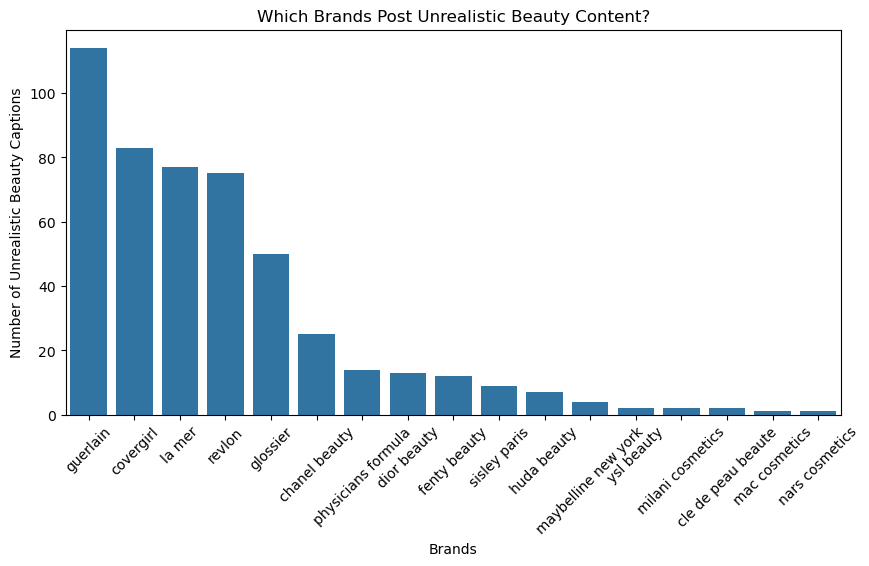

In [15]:
### 4 Analyzing Brand-Level Promotion of Unrealistic Beauty Standards ###
# Count how many times each brand posts unrealistic beauty content
brand_unrealistic_counts = (
    merged_df[merged_df['unrealistic_beauty'] == 1]['identified_brands']
    .value_counts()
    .drop("No Brand Mentioned", errors="ignore")  # Remove non-branded posts
)

### 5 Data Visualization ###
plt.figure(figsize=(10, 5))
sns.barplot(x=brand_unrealistic_counts.index, y=brand_unrealistic_counts.values)
plt.xticks(rotation=45)
plt.xlabel("Brands")
plt.ylabel("Number of Unrealistic Beauty Captions")
plt.title("Which Brands Post Unrealistic Beauty Content?")
plt.show()


In [16]:
# Exact brand names as they appear in your data

luxury_brands = [
    "Lancôme Official",
    "Dior Beauty Official",
    "Clé de Peau Beauté | クレ・ド・ポー ボーテ",
    "TOM FORD BEAUTY",
    "Estée Lauder",
    "wet n wild beauty",
    "Sisley Paris",
    "YSL Beauty Official",
    "CHANEL BEAUTY",
    "Guerlain"
]

midrange_brands = [
    "NARS Cosmetics",
    "M·A·C Cosmetics",
    "FENTY BEAUTY BY RIHANNA",
    "Urban Decay Cosmetics",
    "Too Faced Cosmetics",
    "Glossier",
    "Benefit Cosmetics US",
    "wet n wild beauty",
    "Tarte Cosmetics",
    "HUDA BEAUTY",
    "Smashbox Cosmetics"
]

drugstore_brands = [
    "L'Oréal Paris Official",
    "Revlon",
    "Maybelline New York",
    "NYX Professional Makeup",
    "wet n wild beauty",
    "Milani Cosmetics",
    "e.l.f. Cosmetics and Skincare",
    "COVERGIRL",
    "Physicians Formula",
    "Rimmel London US"
]

def assign_brand_category(profile):
    profile_lower = str(profile).lower()  # Convert to string and lower-case
    # Check if any luxury brand is mentioned
    for brand in luxury_brands:
        if brand.lower() in profile_lower:
            return "Luxury"
    # Check for midrange brands
    for brand in midrange_brands:
        if brand.lower() in profile_lower:
            return "Midrange"
    # Check for drugstore brands
    for brand in drugstore_brands:
        if brand.lower() in profile_lower:
            return "Drugstore"
    # If none match, return Unknown
    return "Unknown"

# Apply the function to create a new column in merged_df
merged_df['brand_category'] = merged_df['Profile'].apply(assign_brand_category)

# Optionally, display the counts for each category
print(merged_df['brand_category'].value_counts())


brand_category
Luxury       5694
Midrange     4453
Drugstore    4420
Unknown       428
Name: count, dtype: int64


In [17]:
merged_df = merged_df[merged_df['brand_category'] != "Unknown"]
merged_df.head()

,Date,Message,Profile,Network,Number of Likes,Number of comments,"Reactions, Comments & Shares",Post interaction rate,Reach per post,Interactions per impression/view,...,Message-ID,Profile-ID,Link,External Links,post_by_influencer,clean_message,identified_brands,unrealistic_content,unrealistic_beauty,brand_category
0,2025-03-10 10:01:15,Standard sunscreens can weaken under extreme c...,Lancôme Official,INSTAGRAM,808,22,830,-,-,-,...,18269553139252951,1652548021,https://www.instagram.com/p/DHA8SUqtfqW/,NaN,0,standard sunscreens can weaken under extreme c...,No Brand Mentioned,No unrealistic content,0,Luxury
1,2025-03-10 09:17:34,"@Badgalriri, adorned with the elegance of #Jad...",Dior Beauty Official,INSTAGRAM,10033,50,10083,-,-,-,...,18058973306047440,2463047524,https://www.instagram.com/p/DHA3Sa4tJJt/,NaN,1,adorned with the elegance of jadoredior and t...,No Brand Mentioned,No unrealistic content,0,Luxury
2,2025-03-10 04:00:49,Glow before you go! ✨ Here’s your 5-step pre-m...,Clé de Peau Beauté | クレ・ド・ポー ボーテ,INSTAGRAM,159,5,164,-,-,-,...,18010379639709699,2680730803,https://www.instagram.com/reel/DHAS_79gLvk/,NaN,1,glow before you go heres your 5step premakeup...,No Brand Mentioned,flawless,1,Luxury
3,2025-03-09 20:30:16,Autumn | Winter 2025\nThe debut collection by ...,TOM FORD BEAUTY,INSTAGRAM,493,4,497,0.000295,-,-,...,18062270557804039,8393187037,https://www.instagram.com/p/DG_cE4YNl5h/,NaN,0,autumn winter 2025\nthe debut collection by h...,No Brand Mentioned,No unrealistic content,0,Luxury
4,2025-03-09 19:04:04,A night routine designed for your skin. Meet P...,Estée Lauder,INSTAGRAM,1598,43,1641,0.000357,-,-,...,17854008231401962,14293571,https://www.instagram.com/reel/DG_Vdm6PFpU/,NaN,0,a night routine designed for your skin meet pa...,No Brand Mentioned,No unrealistic content,0,Luxury


we cleaned the columns to be used

In [18]:


# Clean column names
merged_df.columns = (
    merged_df.columns.str.replace(' ', '_')
                     .str.replace(',', '')
                     .str.replace('-', '_')
)

# Convert relevant columns to numeric
merged_df['Number_of_Likes'] = pd.to_numeric(merged_df['Number_of_Likes'], errors='coerce')
merged_df['unrealistic_beauty'] = pd.to_numeric(merged_df['unrealistic_beauty'], errors='coerce')
merged_df['post_by_influencer'] = pd.to_numeric(merged_df['post_by_influencer'], errors='coerce')
merged_df['brand_category'] = merged_df['brand_category'].astype('category')


#  Multilevel Model Analysis: Social Media Engagement

We conducted two linear mixed-effects models to evaluate how **unrealistic beauty portrayals** and **influencer posts** influence user engagement, measured by:

- **Number of Likes**
- **Number of Comments**

Both models include **random intercepts and slopes** by `brand_category` (Luxury, Midrange, Drugstore) to account for variability in:
- Baseline engagement, and
- Responsiveness to content features across brand tiers.



# 1. Multilevel Model for Number_of_Likes

We estimated a linear mixed-effects model to assess how **unrealistic beauty portrayals** and **influencer posts** influence the number of likes, while allowing these effects to vary across brand categories (Luxury, Midrange, Drugstore). The model includes both **random intercepts** and **random slopes**.

**Model Specification:**

```r
Number_of_Likes ~ unrealistic_beauty + post_by_influencer + (1 + unrealistic_beauty + post_by_influencer | brand_category)

---

In [19]:

# Drop rows with missing values
likes_df = merged_df.dropna(
    subset=['Number_of_Likes', 'unrealistic_beauty', 'post_by_influencer', 'brand_category']
)

# --- Random Intercepts and Slopes Model ---
print("\n### Running full multilevel model for Number_of_Likes ###")
model_likes = Lmer(
    "Number_of_Likes ~ unrealistic_beauty + post_by_influencer + "
    "(1 + unrealistic_beauty + post_by_influencer | brand_category)",
    data=likes_df
)

# Fit the model
model_likes.fit()

# Output summary
print("\n### Random Slopes + Intercepts Model Summary (Likes) ###")
print(model_likes.summary())

# Optional: examine random effects (brand-level slopes and intercepts)
print("\n### Brand-level Random Effects ###")
print(model_likes.ranef)



### Running full multilevel model for Number_of_Likes ###
boundary (singular) fit: see help('isSingular') 



c:\Users\RUTA\.conda\envs\SDM\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
c:\Users\RUTA\.conda\envs\SDM\lib\site-packages\pymer4\models\Lmer.py:744: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_corrs = ran_corrs.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: Number_of_Likes~unrealistic_beauty+post_by_influencer+(1+unrealistic_beauty+post_by_influencer|brand_category)

Family: gaussian	 Inference: parametric

Number of observations: 14516	 Groups: {'brand_category': 3.0}

Log-likelihood: -173564.351 	 AIC: 347148.701

Random effects:

                              Name           Var        Std
brand_category         (Intercept)  1.090042e+07   3301.578
brand_category  unrealistic_beauty  7.558355e+05    869.388
brand_category  post_by_influencer  2.495664e+08  15797.671
Residual                            1.425537e+09  37756.285

                               IV1                 IV2   Corr
brand_category         (Intercept)  unrealistic_beauty  1.000
brand_category         (Intercept)  post_by_influencer -0.727
brand_category  unrealistic_beauty  post_by_influencer -0.727

Fixed effects:


### Random Slopes + Intercepts Model Summary (Likes) ###
Linear mixed model fit by REML [’lmerMod’]




## Fixed Effects (Average Effects Across All Brands)

| Predictor            | Estimate   | 95% CI                   | SE       | T-stat | P-val | Sig. |
|----------------------|------------|---------------------------|----------|--------|--------|------|
| Intercept            | 10,047.10  | [6,227.84, 13,866.36]     | 1,948.64 | 5.16   | 0.036  | *    |
| Unrealistic Beauty   | -2,534.58  | [-4,165.58, -903.59]      | 832.16   | -3.05  | 0.053  | .    |
| Post by Influencer   | 8,588.93   | [-9,388.37, 26,566.22]    | 9,172.26 | 0.94   | 0.450  |      |

**Interpretation**:  
- Unrealistic beauty has a negative average effect on likes (−2,534), and is marginally significant (p = 0.053), suggesting it might reduce user engagement.  
- Influencer posts have a positive but non-significant effect overall (+8,589 likes), but this effect varies widely by brand, as shown below.

---

## Brand-Level Effects (Random Effects)

| Brand     | Baseline Deviation (Intercept) | Effect of Unrealistic Beauty | Effect of Influencer Post |
|-----------|-------------------------------:|------------------------------:|---------------------------:|
| Drugstore | −2,044                         | −538                          | −3,099                     |
| Luxury    | −1,716                         | −452                          | +17,035                    |
| Midrange  | +3,760                         | +990                          | −13,935                    |

**Interpretation**:  
- Luxury brands benefit the most from influencer posts (+17,035), suggesting this strategy is highly effective for premium positioning.  
- Drugstore and Midrange brands show negative or inconsistent effects from influencer content, possibly due to credibility issues or audience mismatch.  
- Unrealistic beauty has slightly negative effects for Luxury and Drugstore, but a positive effect for Midrange. This suggests that brand tone and target audience expectations shape how beauty portrayals are received.

---


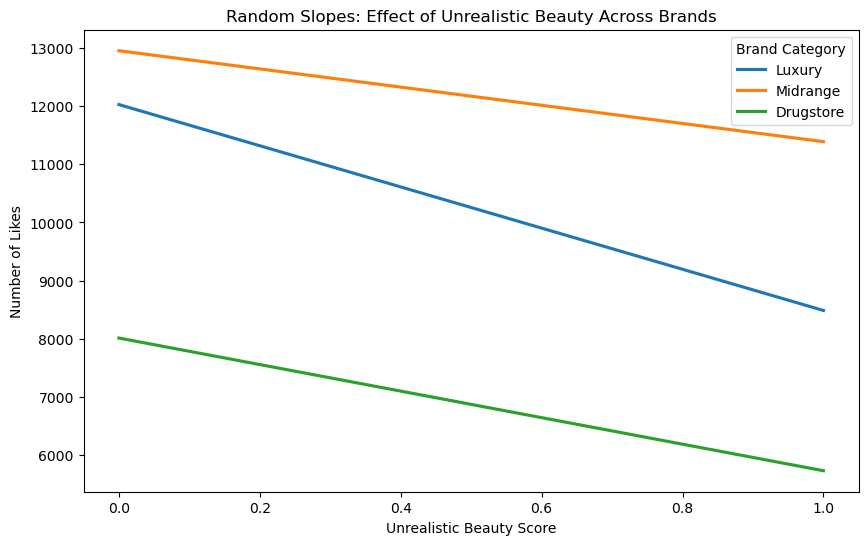

In [20]:
plt.figure(figsize=(10, 6))

# Plot individual brand regression lines
for brand in merged_df["brand_category"].unique():
    df_subset = merged_df[merged_df["brand_category"] == brand]
    sns.regplot(x=df_subset["unrealistic_beauty"], y=df_subset["Number_of_Likes"], scatter=False, label=brand, ci=None)

plt.xlabel("Unrealistic Beauty Score")
plt.ylabel("Number of Likes")
plt.title("Random Slopes: Effect of Unrealistic Beauty Across Brands")
plt.legend(title="Brand Category")
plt.show()


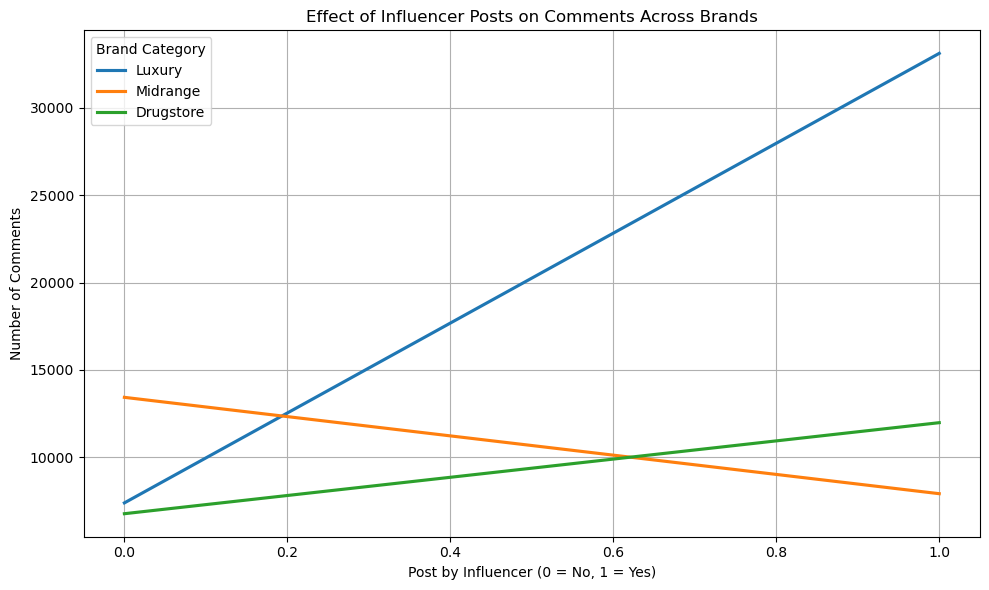

In [21]:
plt.figure(figsize=(10, 6))

# Plot regression lines by brand for POST BY INFLUENCER
for brand in merged_df["brand_category"].unique():
    df_subset = merged_df[merged_df["brand_category"] == brand]
    sns.regplot(
        x="post_by_influencer",
        y="Number_of_Likes",
        data=df_subset,
        scatter=False,
        label=brand,
        ci=None
    )

plt.xlabel("Post by Influencer (0 = No, 1 = Yes)")
plt.ylabel("Number of Comments")
plt.title("Effect of Influencer Posts on Comments Across Brands")
plt.legend(title="Brand Category")
plt.grid(True)
plt.tight_layout()
plt.show()

## Final Conclusion

- The negative effect of unrealistic beauty is fairly consistent across brands, and slightly stronger for Drugstore.  
- Influencer marketing is highly effective for Luxury brands, but may be ineffective or counterproductive for Midrange and Drugstore.  
- This model confirms that content strategies must be tailored to brand tier, as user engagement drivers vary significantly across categories.  
- Using a multilevel model was essential to uncover these insights — a single-level model would have missed this brand-specific variation in effects.

# 2. Multilevel Model for Number_of_comments

**Model Specification:**

We estimated a linear mixed-effects model to assess how **unrealistic beauty portrayals** and **influencer posts** influence the Number_of_comments , while allowing these effects to vary across brand categories (Luxury, Midrange, Drugstore). The model includes both **random intercepts** and **random slopes**.


```r
Number_of_comments ~ unrealistic_beauty + post_by_influencer + (1 + unrealistic_beauty + post_by_influencer | brand_category)


In [22]:
from pymer4.models import Lmer
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='rpy2')

# Drop rows with missing values
comments_df = merged_df.dropna(
    subset=['Number_of_comments', 'unrealistic_beauty', 'post_by_influencer', 'brand_category']
)

# --- Random Intercepts and Slopes Model ---
print("\n### Running full multilevel model for Number_of_Likes ###")
model_likes = Lmer(
    "Number_of_comments ~ unrealistic_beauty + post_by_influencer + "
    "(1 + unrealistic_beauty + post_by_influencer | brand_category)",
    data=comments_df
)

# Fit the model
model_likes.fit()

# Output summary
print("\n### Random Slopes + Intercepts Model Summary (Likes) ###")
print(model_likes.summary())

# Optional: examine random effects (brand-level slopes and intercepts)
print("\n### Brand-level Random Effects ###")
print(model_likes.ranef)



### Running full multilevel model for Number_of_Likes ###
boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: Number_of_comments~unrealistic_beauty+post_by_influencer+(1+unrealistic_beauty+post_by_influencer|brand_category)

Family: gaussian	 Inference: parametric

Number of observations: 14567	 Groups: {'brand_category': 3.0}

Log-likelihood: -123703.179 	 AIC: 247426.358

Random effects:

                              Name          Var       Std
brand_category         (Intercept)     5515.759    74.268
brand_category  unrealistic_beauty      503.255    22.433
brand_category  post_by_influencer    23808.680   154.301
Residual                            1393690.826  1180.547

                               IV1                 IV2   Corr
brand_category         (Intercept)  unrealistic_beauty -0.280
brand_category         (Intercept)  post_by_influencer -0.979
brand_category  unrealistic_beauty  post_by_influencer  0.078

Fixed effects:


c:\Users\RUTA\.conda\envs\SDM\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
c:\Users\RUTA\.conda\envs\SDM\lib\site-packages\pymer4\models\Lmer.py:744: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_corrs = ran_corrs.applymap(


# Multilevel Model Summary: Effect on Number of Comments

We estimated a linear mixed-effects model to examine how **unrealistic beauty portrayals** and **influencer posts** affect the **number of comments** on social media content. The model includes **random intercepts** and **random slopes** for `brand_category` to capture brand-level variation in both baseline engagement and predictor effects.

---

## Fixed Effects (Average Effects Across All Brands)

| Predictor            | Estimate  | 95% CI                    | SE      | T-stat | P-val | Sig. |
|----------------------|-----------|----------------------------|---------|--------|--------|------|
| Intercept            | 170.37    | [82.76, 257.98]            | 44.70   | 3.81   | 0.061  | .    |
| Unrealistic Beauty   | -60.11    | [-108.05, -12.17]          | 24.46   | -2.46  | 0.126  |      |
| Post by Influencer   | 70.75     | [-112.97, 254.48]          | 93.74   | 0.76   | 0.527  |      |

**Interpretation**:  
- The average effect of **unrealistic beauty** is negative (−60 comments), suggesting it may reduce engagement, but the effect is **not statistically significant** at p < 0.05.
- The effect of **influencer posts** is positive (+71 comments) on average but also **not statistically significant**, indicating variability across brand categories.
- The intercept represents the expected number of comments when both predictors are zero.

---

## Brand-Level Effects (Random Effects)

| Brand     | Baseline Deviation (Intercept) | Effect of Unrealistic Beauty | Effect of Influencer Post |
|-----------|-------------------------------:|------------------------------:|---------------------------:|
| Drugstore | +34.43                         | −14.94                        | −52.49                     |
| Luxury    | −82.78                         | +6.34                         | +169.34                    |
| Midrange  | +48.35                         | +8.60                         | −116.84                    |

**Interpretation**:  
- **Luxury brands** show the strongest positive effect from influencer posts (+169 comments), indicating that influencers are especially impactful for premium brands.
- **Drugstore and Midrange brands** have negative or inconsistent effects from influencer posts, which may reflect differences in credibility or audience resonance.
- The effect of **unrealistic beauty** is slightly negative for Drugstore and slightly positive for Luxury and Midrange, indicating brand-specific responses to beauty portrayals.
- Brand baselines vary, with Midrange and Drugstore generally receiving more comments than Luxury, after accounting for predictors.

---




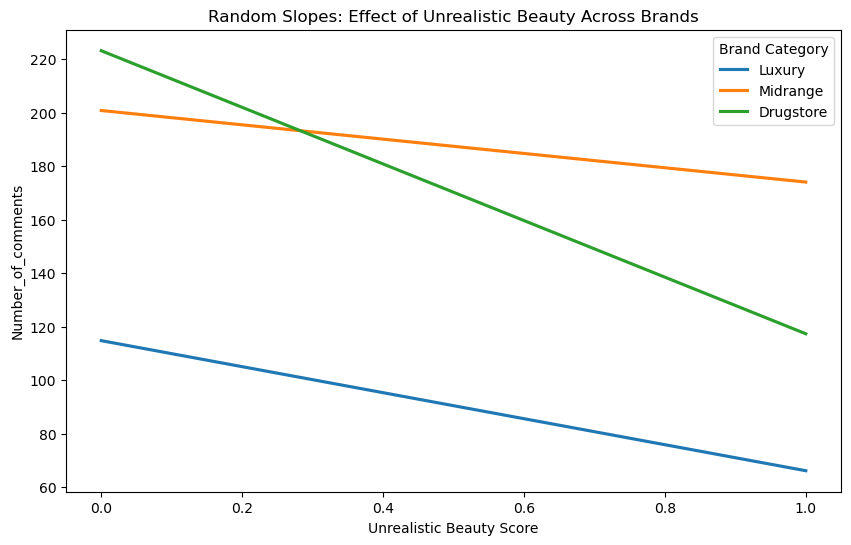

In [23]:
plt.figure(figsize=(10, 6))

# Plot individual brand regression lines
for brand in merged_df["brand_category"].unique():
    df_subset = merged_df[merged_df["brand_category"] == brand]
    sns.regplot(x=df_subset["unrealistic_beauty"], y=df_subset["Number_of_comments"], scatter=False, label=brand, ci=None)

plt.xlabel("Unrealistic Beauty Score")
plt.ylabel("Number_of_comments")
plt.title("Random Slopes: Effect of Unrealistic Beauty Across Brands")
plt.legend(title="Brand Category")
plt.show()


This visualization shows that **higher unrealistic beauty scores reduce audience engagement through comments across all brand categories**. **Drugstore brands**, which start with the highest comments, experience the **steepest decline**, suggesting their audience is **more reactive** to unrealistic beauty portrayals. **Midrange brands** maintain the highest engagement with a **smaller decline**, indicating their audience is **less sensitive** to unrealistic beauty. **Luxury brands consistently receive the fewest comments**, showing **low engagement overall**, regardless of unrealistic beauty levels.


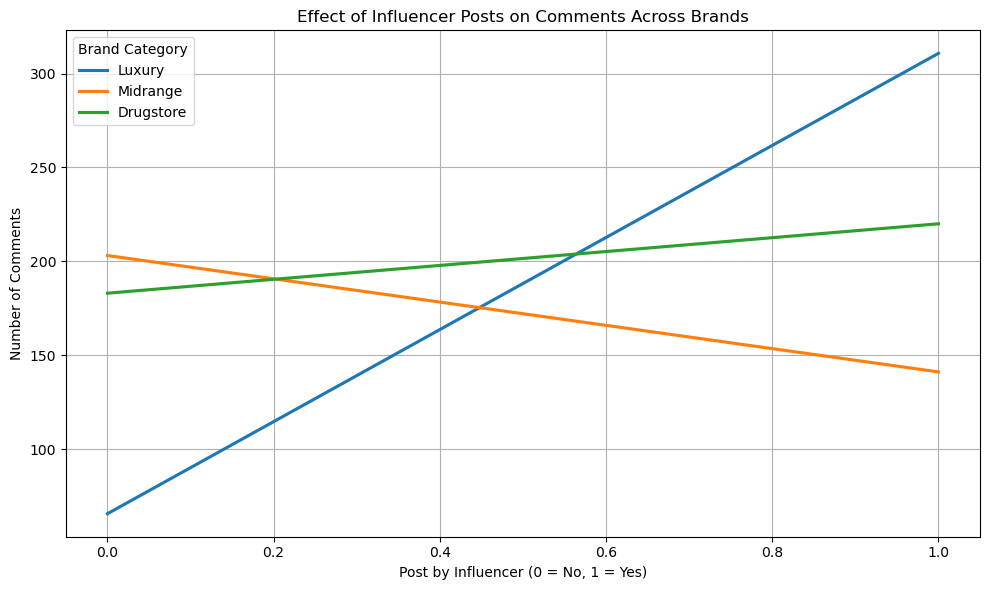

In [24]:
plt.figure(figsize=(10, 6))

# Plot regression lines by brand for POST BY INFLUENCER
for brand in merged_df["brand_category"].unique():
    df_subset = merged_df[merged_df["brand_category"] == brand]
    sns.regplot(
        x="post_by_influencer",
        y="Number_of_comments",
        data=df_subset,
        scatter=False,
        label=brand,
        ci=None
    )

plt.xlabel("Post by Influencer (0 = No, 1 = Yes)")
plt.ylabel("Number of Comments")
plt.title("Effect of Influencer Posts on Comments Across Brands")
plt.legend(title="Brand Category")
plt.grid(True)
plt.tight_layout()
plt.show()



## Final Conclusion

- While the average effects of beauty portrayals and influencer content are **not statistically significant**, the **variation across brand categories is substantial**, especially for influencer content.
- **Luxury brands benefit most** from influencer-driven posts, whereas **Drugstore and Midrange brands may need alternative strategies** to drive engagement.
- **Multilevel modeling was essential** to detect these nuanced patterns, revealing that engagement strategies should be **brand-type specific**.